# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import imageio
import os
from data import *

from kernels import *
from sparse_gp import *

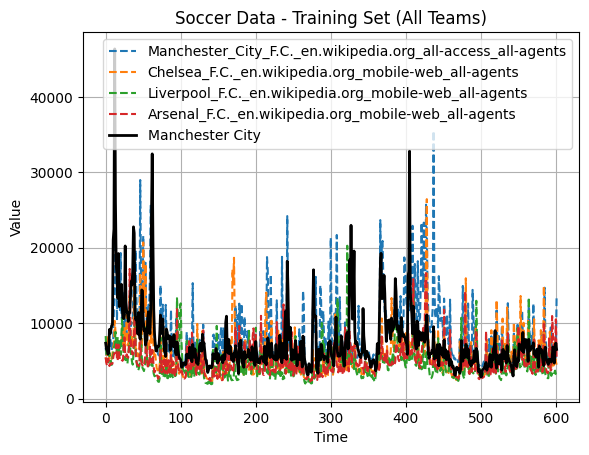

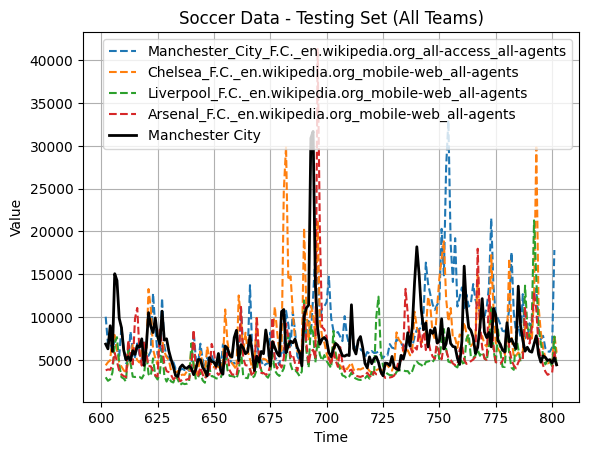

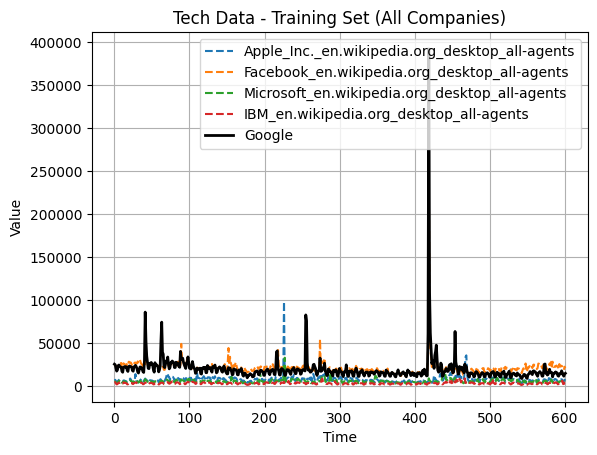

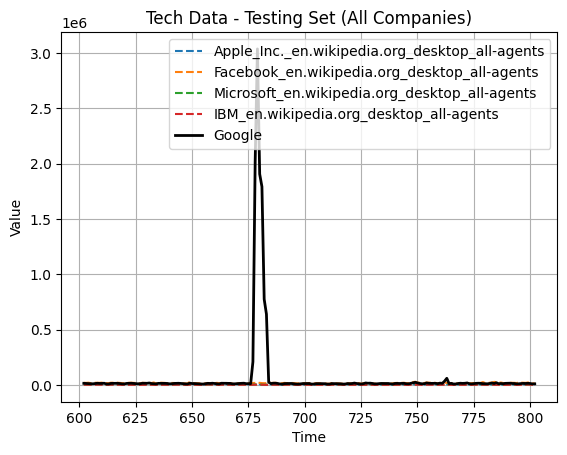

In [3]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# Example: Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(soccer, train_ratio=0.75, target_column=0)

# Generate integer day labels
time_train = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Soccer group feature names (e.g., team names)
soccer_feature_names = [row[0] for row in soccer if row[0] != soccer[0, 0]]

# Plot all soccer teams in the training set
plot_time_series(
    X=X_train_soccer, 
    Y=y_train_soccer, 
    time=time_train, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_time_series(
    X=X_test_soccer, 
    Y=y_test_soccer, 
    time=time_test, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Testing Set (All Teams)"
)

# Example: Repeat for Tech data
X_train_tech, X_test_tech, y_train_tech, y_test_tech = split_train_test_matrix(tech, train_ratio=0.75, target_column=0)

# Generate integer day labels for Tech
time_train_tech = np.arange(X_train_tech.shape[0])
time_test_tech = np.arange(X_train_tech.shape[0], X_train_tech.shape[0] + X_test_tech.shape[0])

# Tech group feature names (e.g., companies)
tech_feature_names = [row[0] for row in tech if row[0] != tech[0, 0]]

# Plot all tech companies in the training set
plot_time_series(
    X=X_train_tech, 
    Y=y_train_tech, 
    time=time_train_tech, 
    feature_names=tech_feature_names, 
    target_name="Google",  # Example target
    title="Tech Data - Training Set (All Companies)"
)

# Plot all tech companies in the testing set
plot_time_series(
    X=X_test_tech, 
    Y=y_test_tech, 
    time=time_test_tech, 
    feature_names=tech_feature_names, 
    target_name="Google",  # Example target
    title="Tech Data - Testing Set (All Companies)"
)


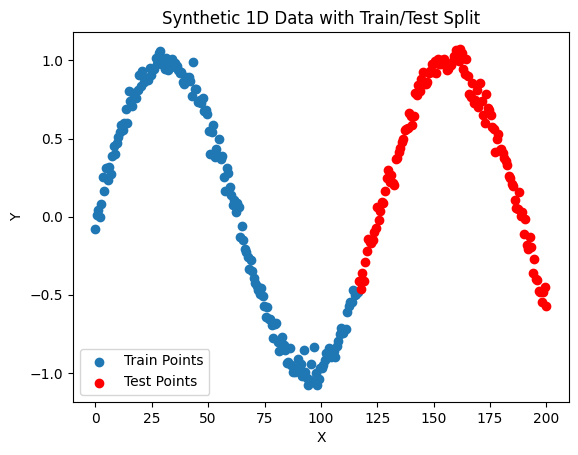

In [3]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Predictive Mean and Uncertainty Plot

In [4]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn):
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)
    numInducing = Z.shape[0]

    # Make predictions on the test set using the optimized hyperparameters
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays for plotting and ensure all are 1D
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()

    # Ensure all variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot the points, predictive mean, and confidence interval
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")

    # Plot predictive mean line and 95% confidence interval
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     (posterior_mean - 1.96 * onp.sqrt(posterior_var)),
                     (posterior_mean + 1.96 * onp.sqrt(posterior_var)),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title(f"Sparse GP Prediction with Uncertainty (Including {numInducing} Inducing Points)")
    plt.show()
#

### Negative Log Predictive Density Plot

In [5]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn, noise_variance):
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

### ELBO Plot

In [6]:
def plot_elbo(history):
    # Extract ELBO values and steps from history
    elbo_values = [entry["elbo"] for entry in history]
    steps = [entry["step"] for entry in history]
    
    # Plot the ELBO values over steps
    plt.figure(figsize=(10, 5))
    plt.plot(steps, elbo_values, label="ELBO", color='blue')
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training Steps")
    plt.legend()
    plt.show()
#

### Kernel Hyperparameter Plot

In [7]:
def plot_kernel_hyperparameters(history):
    # Extract training steps
    steps = [entry["step"] for entry in history]
    
    # Function to normalize values between 0 and 1
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) for v in values] if max_val > min_val else values

    # Extract and normalize raw hyperparameters
    weights_1 = normalize([entry["hyperparams"][0] for entry in history])
    weights_2 = normalize([entry["hyperparams"][1] for entry in history])
    weights_3 = normalize([entry["hyperparams"][2] for entry in history])
    noise_variance_sqexp = normalize([entry["hyperparams"][3] for entry in history])
    signal_variance_sqexp = normalize([entry["hyperparams"][4] for entry in history])
    length_scale_sqexp = normalize([entry["hyperparams"][5] for entry in history])
    noise_variance_linear = normalize([entry["hyperparams"][6] for entry in history])
    signal_variance_linear = normalize([entry["hyperparams"][7] for entry in history])
    noise_variance_matern = normalize([entry["hyperparams"][8] for entry in history])
    signal_variance_matern = normalize([entry["hyperparams"][9] for entry in history])
    length_scale_matern = normalize([entry["hyperparams"][10] for entry in history])
    nu_matern = normalize([entry["hyperparams"][11] for entry in history])

    
    # Plot normalized kernel hyperparameters
    plt.figure(figsize=(12, 8))

    # Plot for Squared-Exponential Kernel (Blue)
    plt.plot(steps, weights_1, label="Weight (Squared-Exponential Kernel)", color='blue', linestyle='--')
    plt.plot(steps, noise_variance_sqexp, label="Noise Variance (Sq-Exp)", color='blue', linestyle='-.')
    plt.plot(steps, signal_variance_sqexp, label="Signal Variance (Sq-Exp)", color='blue', linestyle='-')
    plt.plot(steps, length_scale_sqexp, label="Length Scale (Sq-Exp)", color='blue', linestyle=':')

    # Plot for Linear Kernel (Red)
    plt.plot(steps, weights_2, label="Weight (Linear Kernel)", color='red', linestyle='--')
    plt.plot(steps, noise_variance_linear, label="Noise Variance (Linear)", color='red', linestyle='-.')
    plt.plot(steps, signal_variance_linear, label="Signal Variance (Linear)", color='red', linestyle='-')

    # Plot for Matern Kernel (Green)
    plt.plot(steps, weights_3, label="Weight (Matern Kernel)", color='green', linestyle='--')
    plt.plot(steps, noise_variance_matern, label="Noise Variance (Matern)", color='green', linestyle='-.')
    plt.plot(steps, signal_variance_matern, label="Signal Variance (Matern)", color='green', linestyle='-')
    plt.plot(steps, length_scale_matern, label="Length Scale (Matern)", color='green', linestyle=':')
    plt.plot(steps, nu_matern, label="Nu (Matern)", color='green', linestyle='--')

    # Plot configuration
    plt.xlabel("Step")
    plt.ylabel("Normalized Parameter Value (0 to 1)")
    plt.title("Normalized Kernel Hyperparameter Values Over Training Steps")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [8]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Three initial weights in log space for unconstrained optimization
    initial_weights = [np.log(0.33), np.log(0.33), np.log(0.33)]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0, 2.5]  # [noise_variance, signal_variance, length_scale, nu]

    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear + hyperparams_matern
    return np.array(initial_params)
#

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [9]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -222.03110875833227
Step 10, ELBO: -199.08553483278237
Step 20, ELBO: -181.38054918004653
Step 30, ELBO: -169.44709011152088
Step 40, ELBO: -162.11540987769027
Step 50, ELBO: -156.6152933012305
Step 60, ELBO: -114.87403661428218
Step 70, ELBO: -92.04991622653421
Step 80, ELBO: -75.52321610834697
Step 90, ELBO: -63.45976100323959
Step 100, ELBO: -54.92484313446539
Step 110, ELBO: -48.93600096107491
Step 120, ELBO: -44.68477930530405
Step 130, ELBO: -41.59934910204795
Step 140, ELBO: -39.301621660175726
Step 150, ELBO: -37.546359554320645
Step 160, ELBO: -36.17359735038522
Step 170, ELBO: -35.077181103498305
Step 180, ELBO: -34.18511336801808
Step 190, ELBO: -33.44743010338064
Step 200, ELBO: -32.82867277178096
Step 210, ELBO: -32.30314080752555
Step 220, ELBO: -31.85183950849148
Step 230, ELBO: -31.460477473984497
Step 240, ELBO: -31.118125706284104
Step 250, ELBO: -30.81630201234853
Step 260, ELBO: -30.548334099010304
Step 270, ELBO: -30.308908772359587
Step 280, ELBO: -3

In [10]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 3 Weights:", np.sum(optimized_hyperparams[:3]))

Optimized Hyperparameters: [1.03323881e+00 1.69736497e-01 2.97550105e-01 1.04603108e-02
 8.54102435e+00 5.29836234e+03 1.04591656e-02 1.45670049e+00
 1.04593127e-02 2.53595069e+00 2.20264942e+04 1.21824947e+01]
sum of First 3 Weights: 1.5005254126397725


## Predict and Plot the Results

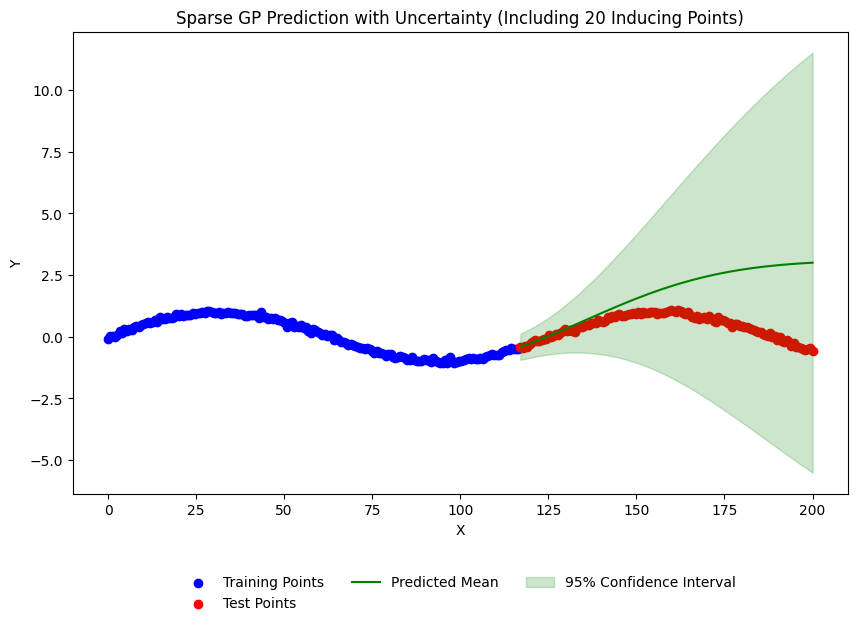

In [11]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [12]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Nu: {optimized_hyperparams[11]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 68.86%
Kernel 2 (Linear): 11.31%
Kernel 3 (Matérn): 19.83%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0105
Kernel 1 - Signal Variance: 8.5410
Kernel 1 - Length Scale: 5298.3623
Kernel 2 - Noise Variance: 0.0105
Kernel 2 - Signal Variance: 1.4567
Kernel 3 - Noise Variance: 0.0105
Kernel 3 - Signal Variance: 2.5360
Kernel 3 - Length Scale: 22026.4942
Kernel 3 - Nu: 12.1825


## NLPD on Test Data

In [13]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.3976
Test NLPD: 2.5450


## ELBO Maximization

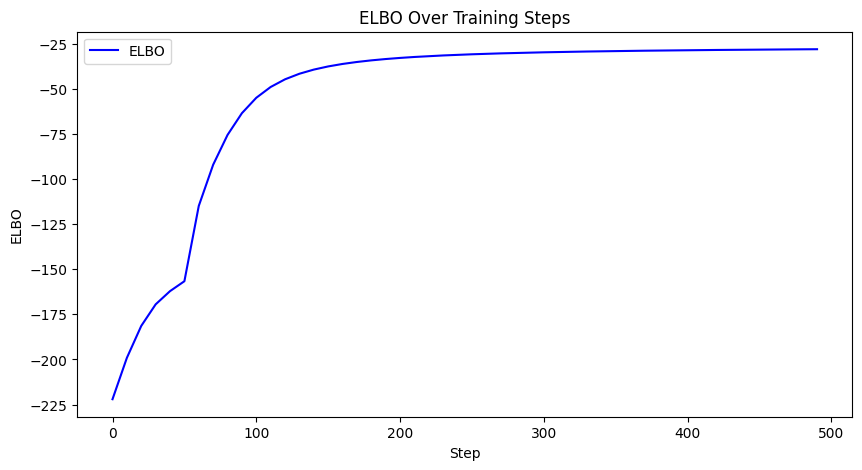

In [14]:
plot_elbo(history)

## Kernel Hyperparameters

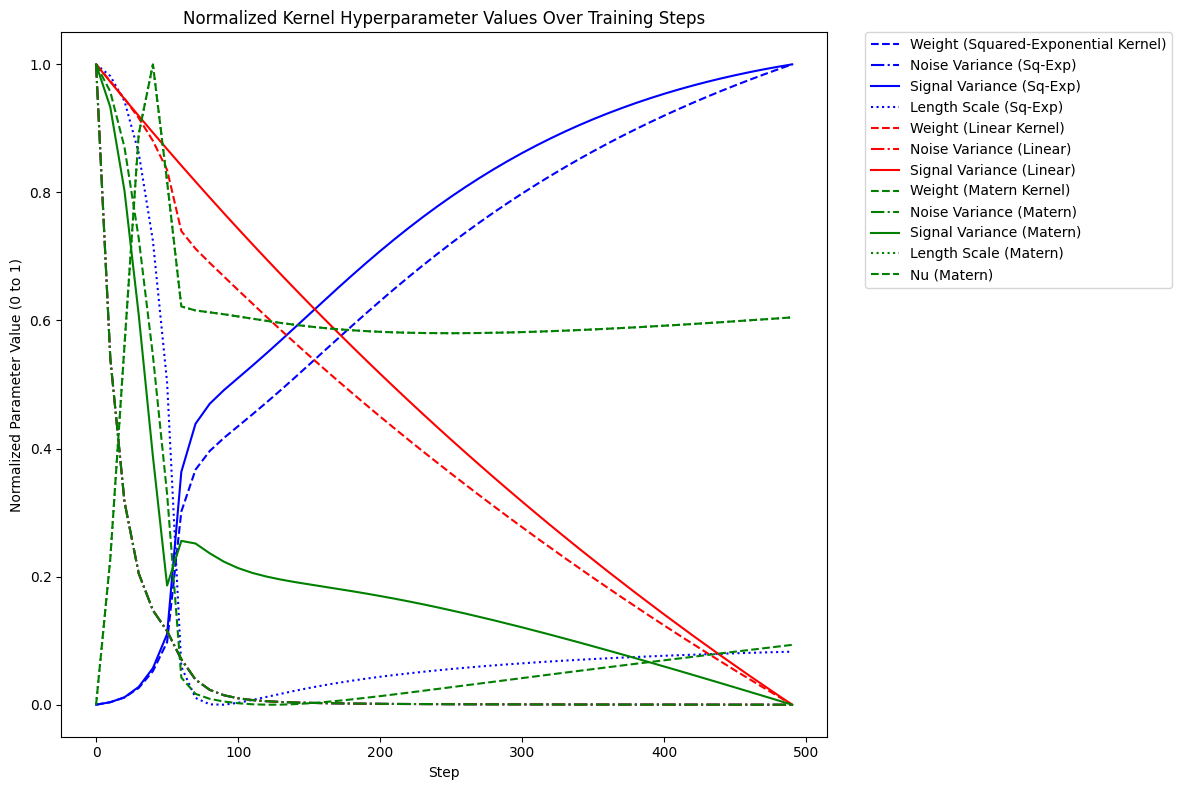

In [15]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [16]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [17]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -222.0215017791673
Step 10, ELBO: -198.9930573645691
Step 20, ELBO: -181.01701142588283
Step 30, ELBO: -168.63819056009612
Step 40, ELBO: -160.25190035116077
Step 50, ELBO: -128.15959697227584
Step 60, ELBO: -100.44196182349262
Step 70, ELBO: -81.75806554194035
Step 80, ELBO: -67.92332162483504
Step 90, ELBO: -58.05001752461466
Step 100, ELBO: -51.134487456760795
Step 110, ELBO: -46.26897998958239
Step 120, ELBO: -42.780012296168664
Step 130, ELBO: -40.214379637102354
Step 140, ELBO: -38.27771110920621
Step 150, ELBO: -36.779236360409996
Step 160, ELBO: -35.59361006079003
Step 170, ELBO: -34.636755223822746
Step 180, ELBO: -33.85097109648078
Step 190, ELBO: -33.19574472129858
Step 200, ELBO: -32.642007005042245
Step 210, ELBO: -32.168475225548804
Step 220, ELBO: -31.759276124478674
Step 230, ELBO: -31.402369049054357
Step 240, ELBO: -31.088478714397922
Step 250, ELBO: -30.810359055454995
Step 260, ELBO: -30.56227632937049
Step 270, ELBO: -30.33964011339009
Step 280, ELBO:

In [18]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.44210839e-01 1.71826362e-01 3.04653640e-01 1.04532874e-02
 7.82825668e+00 5.05189847e+03 1.04526646e-02 1.45633240e+00
 1.04527585e-02 2.57172278e+00 2.20264659e+04 1.21824940e+01]
sum of First 2 Weights: 1.1160372010249107


## Predict and Plot the Results

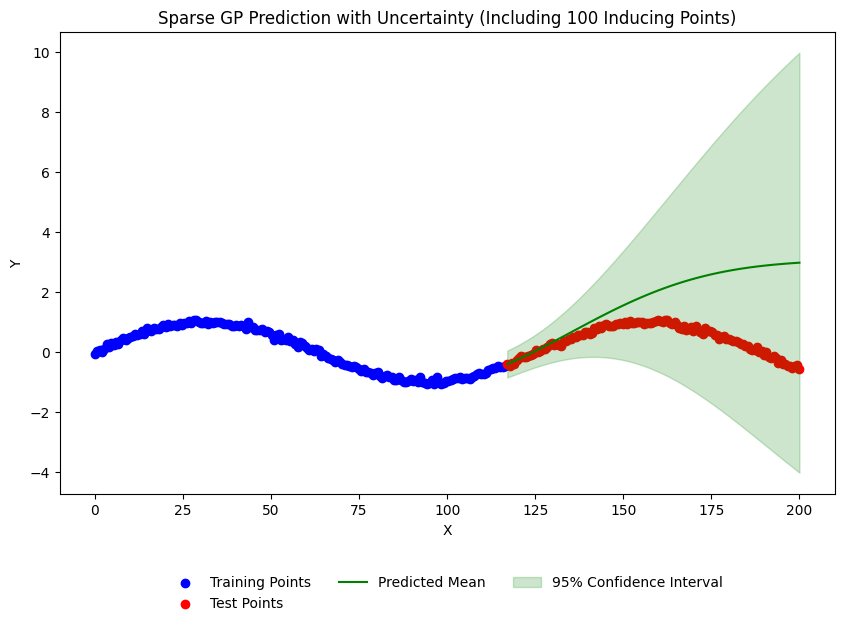

In [19]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [20]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Nu: {optimized_hyperparams[11]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 66.46%
Kernel 2 (Linear): 12.09%
Kernel 3 (Matérn): 21.44%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0105
Kernel 1 - Signal Variance: 7.8283
Kernel 1 - Length Scale: 5051.8985
Kernel 2 - Noise Variance: 0.0105
Kernel 2 - Signal Variance: 1.4563
Kernel 3 - Noise Variance: 0.0105
Kernel 3 - Signal Variance: 2.5717
Kernel 3 - Length Scale: 22026.4659
Kernel 3 - Nu: 12.1825


## NLPD

In [21]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.4001
Test NLPD: 2.6764


## ELBO Maximization


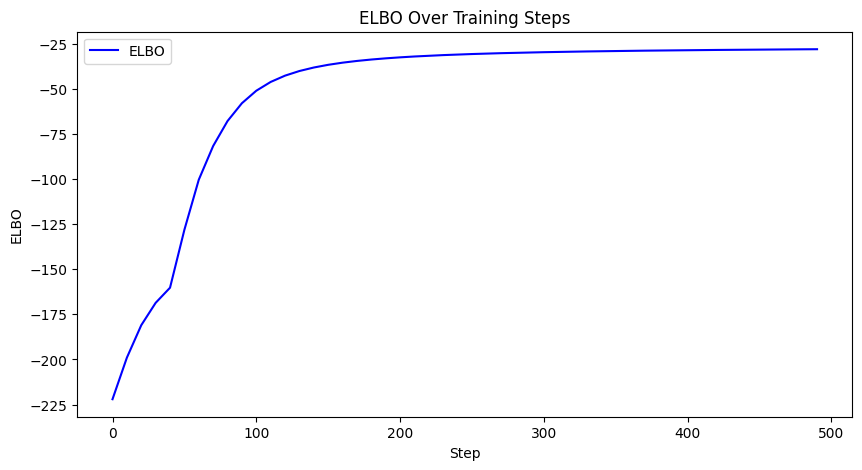

In [22]:
plot_elbo(history)

## Kernel Hyperparameters

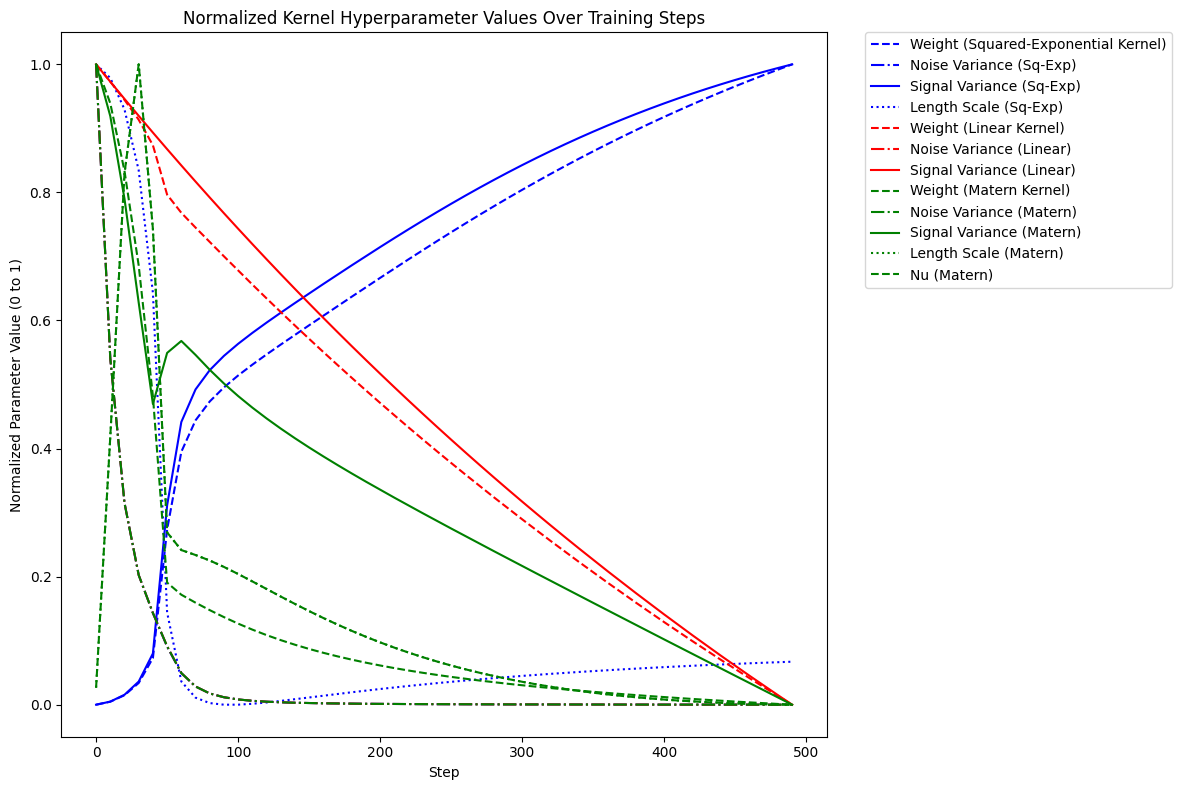

In [23]:
plot_kernel_hyperparameters(history)